In [2]:
import numpy as np
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [9]:
'''
Importing: Importing data as numpy arrays.
'''
DATA_DIR = '/Users/ryankingery/Desktop/data/stl10_binary/'

X_train = np.fromfile(DATA_DIR+'train_X.bin', np.uint8)
y_train = np.fromfile(DATA_DIR+'train_y.bin', np.uint8)
X_test = np.fromfile(DATA_DIR+'test_X.bin', np.uint8)
y_test = np.fromfile(DATA_DIR+'test_y.bin', np.uint8)

print X_train.shape, y_train.shape, X_test.shape, y_test.shape

(138240000,) (5000,) (221184000,) (8000,)


In [10]:
'''
Data Processing: 
    Reshape X-arrays to suit the modeling done below. 
    Feature normalization is performed by dividing by X-arrays by 255.
    Labels y are shifted to 0-9 and one-hot encoded as categorical variables.
'''
X_train = X_train.reshape((5000,3,96,96)).transpose(0,2,3,1).astype('float32')
X_train /= 255
y_train = y_train.reshape((5000,1))
y_train -= 1
y_train = keras.utils.to_categorical(y_train, num_classes=10)
X_test = X_test.reshape((8000,3,96,96)).transpose(0,2,3,1).astype('float32')
X_test /= 255
y_test = y_test.reshape((8000,1))
y_test -= 1
y_test = keras.utils.to_categorical(y_test, num_classes=10)

print X_train.shape, y_train.shape, X_test.shape, y_test.shape

(5000, 96, 96, 3) (5000, 10) (8000, 96, 96, 3) (8000, 10)


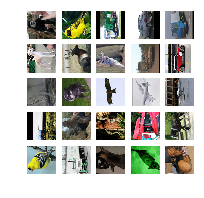

In [5]:
'''
Visualization: Checking that images still look sensible.
'''
fig, axes1 = plt.subplots(5,5,figsize=(3,3))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X_train)))
        axes1[j,k].set_axis_off()
        axes1[j,k].imshow(X_train[i:i+1][0])
plt.show()

In [6]:
'''
Modeling: Using 2D Convolutional Neural Network with 32-32-64-64 convolutional and 512-10 dense layers, 
L2 regularization (by layer) of 0.01, ReLU activatins, cross entropy loss
(note: batch normalization slows performance by a factor of 10 so I had to opt out...using a lowly CPU)
'''
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:],
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same',
                 kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3),kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512,kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10,kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
model.add(Activation('softmax'))

opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [9]:
'''
Training: On training this convnet over 100 epochs I get the following metrics:
          Training Accuracy: 80.2%
          Test Accuracy: 58.5%
Note that STL-10 has achieved test accuracy as high as 72% using more 
specialized models, but mine isn't bad for a fairly quick first pass.
It's certainly much better than the random 10% expected accuracy.
'''
model.fit(X_train, y_train, batch_size=32, epochs=70,\
          validation_data=(X_test,y_test), shuffle=True, verbose=2)
score = model.evaluate(X_test, y_test, batch_size=32)